In [9]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool as mean_pool, global_max_pool as max_pool
import config
import os
import torch
%matplotlib inline
class MyFilter(object):
    def __call__(self, data):
        return data.num_nodes <= 1000
    
    
def statistics(model,data):
    global input_node, input_edge,pool1_node,pool1_edge,pool2_node,pool2_edge,pool3_node,pool3_edge 
    x, edge_index, batch = data.x, data.edge_index, data.batch
    input_node.append(x.shape[0])
    input_edge.append(edge_index.shape[1])

    #for name, module in self.model._modules.items():#生成每一层结果，迭代生成所需pooling层的结果
    x=F.relu(model._modules["conv1"](x, edge_index))

    x, edge_index, _, batch, _ =model._modules["pool1"](x, edge_index, None, batch,layer="layer1")
    

    pool1_node.append(x.shape[0])
    pool1_edge.append(edge_index.shape[1])
    x_output1 = torch.cat([mean_pool(x, batch), max_pool(x, batch  )], dim=1)
    x=F.relu(model._modules["conv2"](x, edge_index))

    x, edge_index, _, batch, _ =model._modules["pool2"](x, edge_index, None, batch,layer="layer2")

    pool2_node.append(x.shape[0])
    pool2_edge.append(edge_index.shape[1])
    x_output2 = torch.cat([mean_pool(x, batch), max_pool(x, batch  )], dim=1)
    x=F.relu(model._modules["conv3"](x, edge_index))

    x, edge_index, _, batch, _ =model._modules["pool3"](x, edge_index, None, batch,layer="layer3")

    pool3_node.append(x.shape[0])
    pool3_edge.append(edge_index.shape[1])
    x_output3 = torch.cat([mean_pool(x, batch), max_pool(x, batch  )], dim=1)
    x = x_output1 + x_output2 + x_output3
        
    return x,input_node,input_edge,pool1_node,pool1_edge,pool2_node,pool2_edge,pool3_node,pool3_edge#输出卷积层的结果

input_node = []
input_edge = []
pool1_node = []
pool1_edge = []
pool2_node = []
pool2_edge = []
pool3_node = []
pool3_edge = []

dataset = TUDataset(os.path.join("DD"),name="DD",pre_filter=MyFilter(),use_node_attr=True)
data_loader = DataLoader(dataset,batch_size=1,shuffle=True)
model = torch.load('DD_model_SAGPool.pkl')
for i, data in enumerate(data_loader):
    data = data.to("cuda:0")
    if i==1000:
        break  
    else:
        x,input_node,input_edge,pool1_node,pool1_edge,pool2_node,pool2_edge,pool3_node,pool3_edge=statistics(model,data)

E:\Anaconda3\envs\pytorch_gpu\lib\site-packages\torch\serialization.py:453: SourceChangeWarning: source code of class 'networks.Net' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


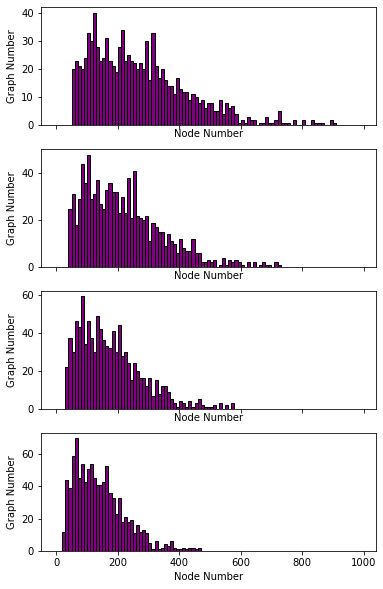

In [10]:
bins = np.arange(0, 1000, 10)
nodes = [
    input_node,pool1_node,pool2_node,pool3_node
]

fig, axes = plt.subplots(4, 1, figsize=(6, 10), sharex=True)
for ax, l in zip(axes, nodes):
    ax.set_xlabel('Node Number')
    ax.set_ylabel('Graph Number')
    ax.hist(l, bins=bins ,facecolor="purple", edgecolor="black")
plt.savefig(r'C:\Users\wujin\OneDrive\Desktop\gnn_design\layer_information\sagpool\Histogram of the node number.png',dpi=300)
plt.savefig(r'C:\Users\wujin\OneDrive\Desktop\gnn_design\layer_information\sagpool\Histogram of the node number.eps',dpi=300)

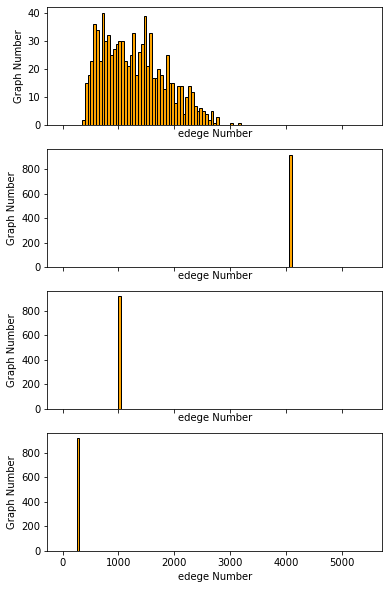

In [3]:



bins = np.arange(0, 5500, 50)
nodes = [
    input_edge,pool1_edge,pool2_edge,pool3_edge
]

fig, axes = plt.subplots(4, 1, figsize=(6, 10), sharex=True)
for ax, l in zip(axes, nodes):
    ax.set_xlabel('edege Number')
    ax.set_ylabel('Graph Number')
    ax.hist(l, bins=bins ,facecolor="orange", edgecolor="black")

plt.savefig(r'C:\Users\wujin\OneDrive\Desktop\gnn_design\layer_information\edgepool\Histogram of the pool1 node number.png')




